In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import geom
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import LogisticRegression as LogR
from sklearn.tree import DecisionTreeRegressor as DT

In [2]:
n = 5000
df = pd.DataFrame()
df['age'] = np.random.randint(25, 76, size=n)

In [3]:
df

,age
0,75
1,41
2,73
3,67
4,40
...,...
4995,34
4996,73
4997,45
4998,40


In [4]:
a=-10.5
b=0.05
timeout = 365*3

In [5]:
prob_values = 1/(1+np.exp(-a-b*df['age']))

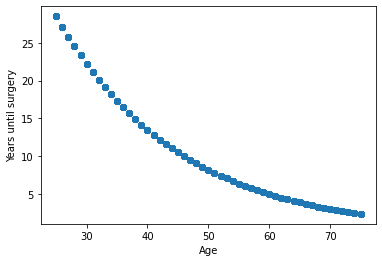

In [6]:
plt.scatter(df['age'],1/(365*prob_values))
plt.xlabel('Age')
plt.ylabel('Years until surgery');

In [7]:
days = geom(prob_values).rvs()
df['observation'] = np.where(days <= timeout, days, np.nan)
df

,age,observation
0,75,199.0
1,41,1095.0
2,73,336.0
3,67,NaN
4,40,NaN
...,...,...
4995,34,NaN
4996,73,88.0
4997,45,931.0
4998,40,204.0


In [8]:
(df['observation'].isna()).mean()

0.6456

In [9]:
days.max()/365

181.15890410958903

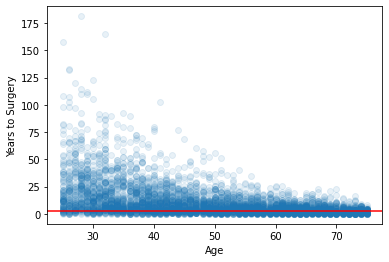

In [10]:
plt.scatter(df['age'],days/365, alpha=.1)
plt.axhline(timeout/365, color='red')
plt.xlabel('Age')
plt.ylabel('Years to Surgery');

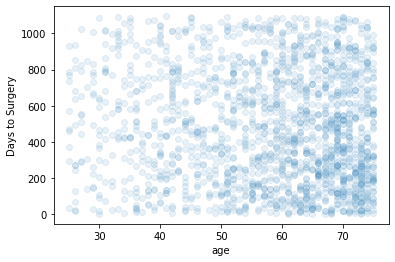

In [11]:
plt.scatter(df['age'], df['observation'], alpha = .1)
plt.xlabel('age')
plt.ylabel('Days to Surgery');

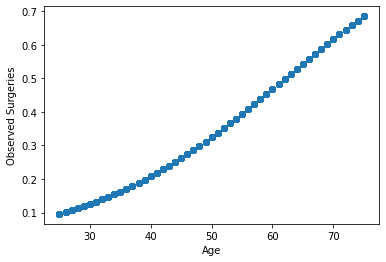

In [12]:
S = LogR().fit(df[['age']],df['observation'].isna()).predict_proba(df[['age']])[:,0]
plt.scatter(df['age'], S)
plt.xlabel('Age')
plt.ylabel('Observed Surgeries');

In [13]:
df['imputed_days'] = np.where(df['observation'].isna(), timeout + (1/(1-(1-S)**(1/timeout))), df['observation'])
df

,age,observation,imputed_days
0,75,199.0,199.000000
1,41,1095.0,1095.000000
2,73,336.0,336.000000
3,67,NaN,2382.233199
4,40,NaN,5783.979661
...,...,...,...
4995,34,NaN,7606.101883
4996,73,88.0,88.000000
4997,45,931.0,931.000000
4998,40,204.0,204.000000


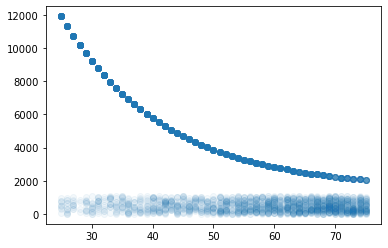

In [14]:
plt.scatter(df['age'], df['imputed_days'], alpha = .05)

In [15]:
df['probability'] = 1/DT().fit(df[['age']], df['imputed_days']).predict(df[['age']])
df

,age,observation,imputed_days,probability
0,75,199.0,199.000000,0.001084
1,41,1095.0,1095.000000,0.000232
2,73,336.0,336.000000,0.001096
3,67,NaN,2382.233199,0.000792
4,40,NaN,5783.979661,0.000226
...,...,...,...,...
4995,34,NaN,7606.101883,0.000152
4996,73,88.0,88.000000,0.001096
4997,45,931.0,931.000000,0.000277
4998,40,204.0,204.000000,0.000226


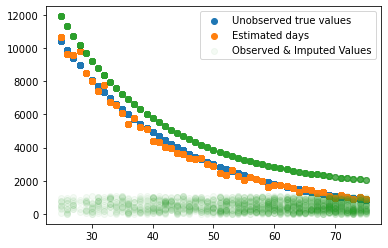

In [16]:
plt.scatter(df['age'],1/prob_values, label = 'Unobserved true values');
plt.scatter(df['age'], 1/df['probability'], label = 'Estimated days')
plt.scatter(df['age'], df['imputed_days'], alpha = .05, label = 'Observed & Imputed Values')
plt.legend()

In [17]:
log_odds = np.log(df['probability']/(1-df['probability']))
log_odds

0      -6.826180
1      -8.368413
2      -6.815279
3      -7.140241
4      -8.394337
          ...   
4995   -8.792705
4996   -6.815279
4997   -8.189555
4998   -8.394337
4999   -7.964513
Name: probability, Length: 5000, dtype: float64

In [18]:
lr = LR().fit(df[['age']], log_odds)

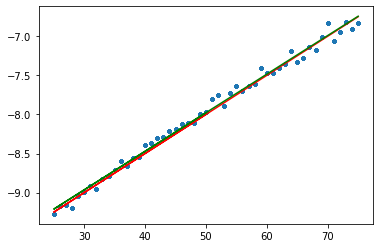

In [19]:
plt.scatter(df['age'], log_odds, s=10)
plt.plot(df['age'], df['age']*b+a, color = 'red')
plt.plot(df['age'], lr.predict(df[['age']]), color = 'green');

In [20]:
lr.intercept_, a

(-10.445488267833527, -10.5)

In [21]:
lr.coef_, b

(array([0.04935192]), 0.05)

In [22]:
df['target']= df['probability'].apply(lambda p:geom(p).cdf(18*30)-geom(p).cdf(6*30))
df

,age,observation,imputed_days,probability,target
0,75,199.0,199.000000,0.001084,0.265893
1,41,1095.0,1095.000000,0.000232,0.076867
2,73,336.0,336.000000,0.001096,0.267696
3,67,NaN,2382.233199,0.000792,0.215164
4,40,NaN,5783.979661,0.000226,0.075060
...,...,...,...,...,...
4995,34,NaN,7606.101883,0.000152,0.051756
4996,73,88.0,88.000000,0.001096,0.267696
4997,45,931.0,931.000000,0.000277,0.090440
4998,40,204.0,204.000000,0.000226,0.075060


/home/land/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


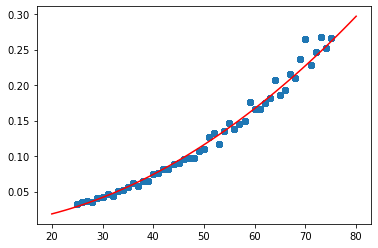

In [23]:
plt.scatter(df['age'], df['target'])
ages = np.linspace(20, 80)
plt.plot(ages, np.exp(LR().fit(np.log(df[['age']]),
                                       np.log(df['target'])
                                      )
                              .predict(np.log(ages.reshape(-1,1)))),
                            color = 'red');


# What if we want to predict outside of our observation window?

#### How many people in this population would have surgery within 3-5 years?

In [47]:
((days>(3*365))&(days<(5*365))*1).sum()

730

#### How many were *observed* to have surgery in 3-5 years?

In [48]:
((df['observation']>(3*365))&(df['observation']<(5*365))*1).sum()

0

#### How many people do we *predict* will have surgery in 3-5 years?

In [49]:
df['probability'].apply(lambda p:geom(p).cdf(5*365)-geom(p).cdf(3*365)).sum()

705.5247080919304